In [1]:
import cartopy
import cmocean
import GMesh
import imp
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import ThinWalls
%matplotlib inline

<GMesh nj:19 ni:20 shape:(19,20)>


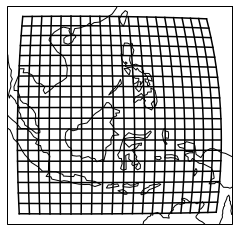

In [2]:
#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
imp.reload(GMesh)
target_mesh = GMesh.GMesh( lon=np.linspace(100, 120, 11), lat=np.linspace(-12, 10, 12) )
target_mesh = GMesh.GMesh( lon=np.linspace(100, 140, 21), lat=np.linspace(-14, 24, 20) )
print( target_mesh )
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
ax.coastlines()
target_mesh.plot(ax, transform=cartopy.crs.Geodetic())

In [3]:
# URL of topographic data, names of longitude, latitude and elevation variables
# url,vx,vy,ve = '/archive/gold/datasets/topography/GEBCO_08_v1.nc','longitude','latitude','depth'
url,vx,vy,ve = '/net2/nnz/thin-wall-topography/python/workdir/GEBCO_2014_2D.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO1/.z_bedrock/dods','lon','lat','z_bedrock'
topo_data = netCDF4.Dataset(url)

# Read coordinates of topography
topo_lon = np.array( topo_data.variables[vx][:] )
topo_lat = np.array( topo_data.variables[vy][:] )
print('topography grid array shapes: ' , topo_lon.shape,topo_lat.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())

print('Is mesh uniform?', GMesh.is_mesh_uniform( topo_lon, topo_lat ) )

# Indices in topographic data
ti,tj = target_mesh.find_nn_uniform_source( topo_lon, topo_lat )
tis,tjs = slice(ti.min(), ti.max()+1,5), slice(tj.min(), tj.max()+1,5)
print('Slices:', tis, tjs )

# Read elevation data
topo_elv = topo_data.variables[ve][tjs,tis]
# Extract appropriate coordinates
topo_lon = topo_lon[tis]
topo_lat = topo_lat[tjs]

print('Topo shape:', topo_elv.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())

topography grid array shapes:  (43200,) (21600,)
topography longitude range: -179.99583333333334 179.99583333332703
topography latitude range: -89.99583333333332 89.99583333333334
Is mesh uniform? True
Slices: slice(33600, 38401, 5) slice(9119, 13680, 5)
Topo shape: (913, 961)
topography longitude range: 100.00416666666666 140.00416666666666
topography latitude range: -14.004166666666666 23.995833333333334


In [4]:
topo_mesh = GMesh.GMesh( lon=topo_lon, lat=topo_lat, from_cell_center=True)

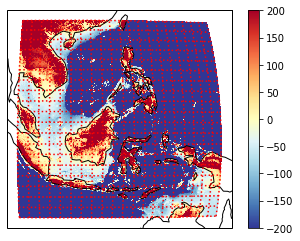

In [5]:
clim, cmap = 200, plt.cm.RdYlBu_r
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
ax.coastlines()
im = topo_mesh.pcolormesh( ax, topo_elv, cmap=cmap, vmin=-clim, vmax=clim, transform=cartopy.crs.PlateCarree() )
target_mesh.plot(ax, linecolor='r:', transform=cartopy.crs.PlateCarree())
plt.colorbar(im, ax=ax);

In [6]:
R = target_mesh.refine_loop( topo_lon, topo_lat )

<GMesh nj:19 ni:20 shape:(19,20)> Hit 420 out of 877393 cells (0.0058 Mb)
<GMesh nj:38 ni:40 shape:(38,40)> Hit 1599 out of 877393 cells (0.0232 Mb)
<GMesh nj:76 ni:80 shape:(76,80)> Hit 6237 out of 877393 cells (0.0928 Mb)
<GMesh nj:152 ni:160 shape:(152,160)> Hit 24633 out of 877393 cells (0.3711 Mb)
<GMesh nj:304 ni:320 shape:(304,320)> Hit 97905 out of 877393 cells (1.4844 Mb)
<GMesh nj:608 ni:640 shape:(608,640)> Hit 390369 out of 877393 cells (5.9375 Mb)
<GMesh nj:1216 ni:1280 shape:(1216,1280)> Hit 877393 out of 877393 cells (23.7500 Mb)


In [7]:
imp.reload(ThinWalls)
FG = ThinWalls.ThinWalls(lon=R[-1].lon, lat=R[-1].lat)

In [8]:
ti,tj = FG.find_nn_uniform_source( topo_lon, topo_lat, nodes=False )
FG.set_cell_mean( topo_elv[tj,ti] )
FG.set_edge_to_step()
FG.init_effective_values()

In [9]:
CG = FG
for iter in range(len(R)-1):
    CG = CG.coarsen()
    CG.info()

ThinWalls(608x640)
ThinWalls(304x320)
ThinWalls(152x160)
ThinWalls(76x80)
ThinWalls(38x40)
ThinWalls(19x20)


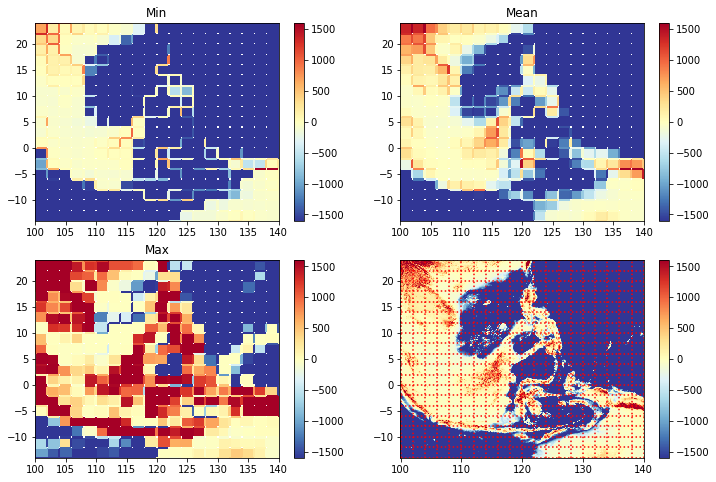

In [10]:
clim, cmap = 1600, plt.cm.RdYlBu_r
plt.figure(figsize=(12,8))
ax = plt.subplot(221)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = CG.plot(ax, metric='min', measure='effective', cmap=cmap, vmin=-clim, vmax=clim); plt.colorbar(im); plt.title('Min');
ax = plt.subplot(222)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = CG.plot(ax, metric='mean', measure='effective', cmap=cmap, vmin=-clim, vmax=clim); plt.colorbar(im); plt.title('Mean');
ax = plt.subplot(223)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = CG.plot(ax, metric='max', measure='effective', cmap=cmap, vmin=-clim, vmax=clim); plt.colorbar(im); plt.title('Max');
ax = plt.subplot(224)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0)); ax.coastlines()
im = topo_mesh.pcolormesh( ax, topo_elv, cmap=cmap, vmin=-clim, vmax=clim) #, transform=cartopy.crs.PlateCarree() )
target_mesh.plot(ax, linecolor='r:')#, transform=cartopy.crs.PlateCarree())
plt.colorbar(im, ax=ax);

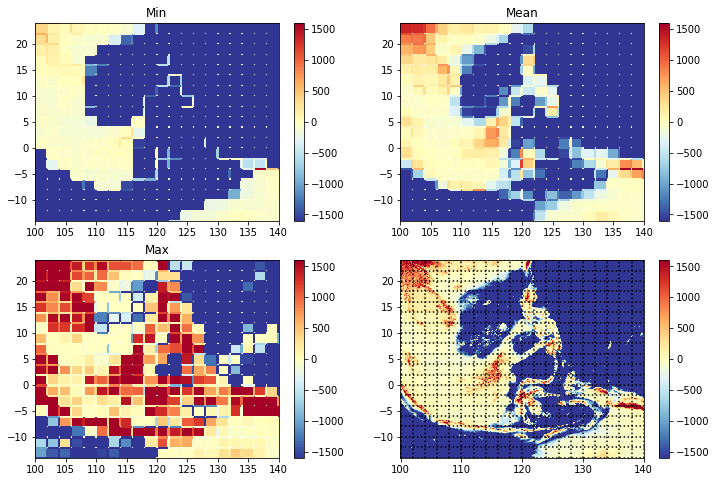

In [11]:
plt.figure(figsize=(12,8))
ax = plt.subplot(221)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = CG.plot(ax, metric='min', measure='simple', cmap=cmap, vmin=-clim, vmax=clim); plt.colorbar(im); plt.title('Min');
ax = plt.subplot(222)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = CG.plot(ax, metric='mean', measure='simple', cmap=cmap, vmin=-clim, vmax=clim); plt.colorbar(im); plt.title('Mean');
ax = plt.subplot(223)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = CG.plot(ax, metric='max', measure='simple', cmap=cmap, vmin=-clim, vmax=clim); plt.colorbar(im); plt.title('Max');
ax = plt.subplot(224)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0)); ax.coastlines()
im = topo_mesh.pcolormesh( ax, topo_elv, cmap=cmap, vmin=-clim, vmax=clim) #, transform=cartopy.crs.PlateCarree() )
target_mesh.plot(ax, linecolor='k:')#, transform=cartopy.crs.PlateCarree())
plt.colorbar(im, ax=ax);

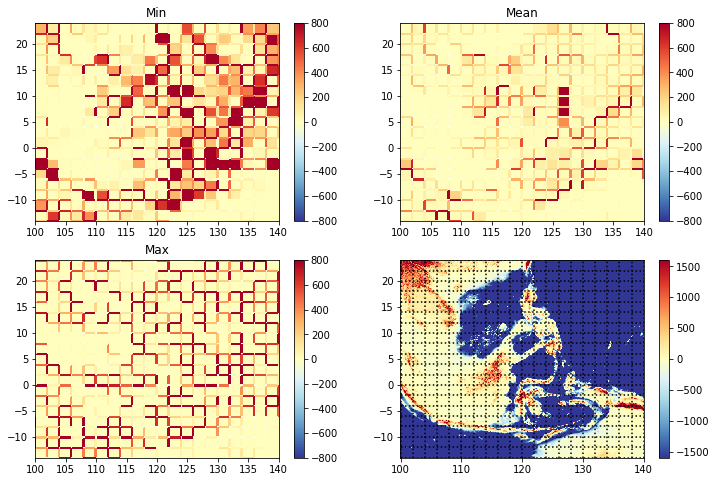

In [12]:
plt.figure(figsize=(12,8)); dlim=800
ax = plt.subplot(221)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = CG.plot(ax, metric='min', measure='diff', cmap=cmap, vmin=-dlim, vmax=dlim); plt.colorbar(im); plt.title('Min');
ax = plt.subplot(222)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = CG.plot(ax, metric='mean', measure='diff', cmap=cmap, vmin=-dlim, vmax=dlim); plt.colorbar(im); plt.title('Mean');
ax = plt.subplot(223)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = CG.plot(ax, metric='max', measure='diff', cmap=cmap, vmin=-dlim, vmax=dlim); plt.colorbar(im); plt.title('Max');
ax = plt.subplot(224)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0)); ax.coastlines()
im = topo_mesh.pcolormesh( ax, topo_elv, cmap=cmap, vmin=-clim, vmax=clim) #, transform=cartopy.crs.PlateCarree() )
target_mesh.plot(ax, linecolor='k:')#, transform=cartopy.crs.PlateCarree())
plt.colorbar(im, ax=ax);

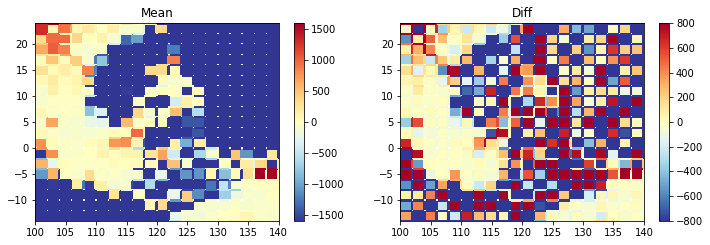

In [13]:
Q = CG.remove_walls()
plt.figure(figsize=(12,8));
ax = plt.subplot(221)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = Q.plot(ax, metric='mean', measure='effective', cmap=cmap, vmin=-clim, vmax=clim); plt.colorbar(im); plt.title('Mean');
ax = plt.subplot(222)#, projection=cartopy.crs.NearsidePerspective(central_longitude=110, central_latitude=0))
im = Q.plot(ax, metric='mean', measure='diff', cmap=cmap, vmin=-dlim, vmax=dlim); plt.colorbar(im); plt.title('Diff');